***Single-Agent Q-learning***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import gym
from gym import spaces

In [20]:
class GridWorldEnv(gym.Env):
    """
    Custom 2D Grid World environment in Gym.
    Gym is for building and testing RL environments.
    """

    def __init__(self, grid_size=(3, 3), start=(0, 0), goal=(2, 2), gamma = 0.9):
        super(GridWorldEnv, self).__init__()

        # Define the grid world size
        self.grid_size = grid_size

        # Define start and goal positions
        self.start = start
        self.goal = goal

        # Set the current position to the start
        self.agent_pos = np.array(self.start)

        # Define action space: 4 possible actions (up, down, left, right)
        # spaces.Discrete is used to create a space of a finite set of elements
        self.action_space = spaces.Discrete(4)  # 0 = down, 1 = left, 2 = up, 3 = right

        # Define observation space (agent's position in the grid)
        # cartesian product of n closed intervals
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)

        # State-value function initialized to 0
        self.V = np.zeros(self.grid_size)

        # Initialize the policy (a random policy for now, can be updated later)
        # Policy: a 5x5 grid where each entry is one of the actions (0=down, 1=left, 2=up, 3=right)
        self.policy = np.random.choice([0, 1, 2, 3], size=self.grid_size)

        # Define discount rate
        self.gamma = gamma

        # Define the movement directions corresponding to actions
        self.movement = {
            0: np.array([1, 0]),  # down
            1: np.array([0, -1]),  # left
            2: np.array([-1, 0]),  # up
            3: np.array([0, 1])  # right
        }

    def reset(self):
        """
        Reset the environment to the initial state (start position).
        """
        self.agent_pos = np.array(self.start)
        return self.agent_pos

    def step(self, action):
        """
        Perform an action and update the environment's state.
        """
        # Update the agent's position
        next_pos = self.agent_pos + self.movement[action]

        # Check if the new position is within grid bounds
        if self._is_valid(next_pos):
            self.agent_pos = next_pos

        # Check if the agent has reached the goal
        if tuple(self.agent_pos) == self.goal:
            reward = 10  # Large reward for reaching the goal
            done = True
        else:
            reward = -1  # Small step penalty
            done = False

        return self.agent_pos, reward, done, {}

    def _is_valid(self, pos):
        """
        Check if the new position is valid (within bounds).
        """
        # Check if position is within bounds
        if 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1]:
            return True
        return False


In [21]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    # initializing Q table with zeros 
    Q = np.zeros((*env.grid_size, env.action_space.n)) # every cell contains the Q value for choosing a certain action

    # start of episode (place the agent at the start and set done to false)
    for episode in range(episodes):
        state = tuple(env.reset())  # Reset environment
        done = False

        while not done:
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit best known action

            # Take action and observe next state & reward
            next_state, reward, done, _ = env.step(action)
            next_state = tuple(next_state)

            # Q-value update using Bellman equation
            Q[state + (action,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action,)])

            # Move to the next state
            state = next_state

        # Optional: Print progress
        if episode % 100 == 0:
            print(f"Episode {episode} completed.")

    return Q


# Train the agent
env = GridWorldEnv()
Q_table = q_learning(env)
print("Training complete! Learned Q-table:")
print(Q_table)

Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Training complete! Learned Q-table:
[[[ 3.78994577  2.75282469  2.85694283  4.58      ]
  [ 6.2         2.98436899  3.65829767  5.43484101]
  [ 7.94346384  0.7812539   0.32672639  0.7381616 ]]

 [[-0.42661     0.07884832 -0.6007095   6.17183384]
  [ 6.84758704  3.97622471  4.21253539  8.        ]
  [10.          5.75048138  4.8119574   7.20582059]]

 [[-0.199      -0.199      -0.19        0.72475026]
  [-0.1        -0.199      -0.1         9.74968445]
  [ 0.          0.          0.          0.        ]]]


In [22]:
def extract_policy(Q):
    """
    Extracts the optimal policy from the Q-table.
    """
    policy = np.argmax(Q, axis=-1)  # Best action for each state
    return policy

optimal_policy = extract_policy(Q_table)
print("Optimal Policy:")
print(optimal_policy)

Optimal Policy:
[[3 0 0]
 [3 3 0]
 [3 3 0]]


In [26]:
def plot_grid_with_policy(env):
    """This method plots the environment of the agent and shows the policy arrows.
    Works for grid environments.

    Args:
        env (GridWorldEnv): The environment to be plotted.
    """
    # Create a copy of the environment grid
    grid = np.zeros(env.grid_size)

    # Define custom colors for the colormap
    colors = ['white', 'black']  # 'white' for free cells
    cmap = mcolors.ListedColormap(colors)

    # Plot the grid with the custom colormap
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=cmap)

    # Display 'F' for the finish line
    ax.text(env.goal[1], env.goal[0], 'F', ha='center', va='center', color='black', fontsize=20)
    ax.text(env.start[1], env.start[0], 'S', ha='center', va='center', color='black', fontsize=20)

    # Define arrow directions based on policy actions
    action_arrows = {
        0: '↓',  # down
        1: '←',  # left
        2: '↑',  # up
        3: '→'   # right
    }

    # Place arrows on the grid based on the policy
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            if (i, j) == env.goal:
                continue
            action = optimal_policy[i, j]  # Get action for the current state
            ax.text(j, i, action_arrows[action], ha='center', va='center', color='blue', fontsize=20)

    # Add grid lines separating each square
    ax.set_xticks(np.arange(-0.5, env.grid_size[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.title("Grid World with Optimal Policy Arrows")
    plt.show()

def plot_value_function(env):
    """Plot the value function with respect to an end point, including grid lines."""
    grid = env.V.copy()

    # Create a new figure
    plt.figure()

    # Plot the grid representing the value function
    plt.imshow(grid, cmap='Purples', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title("Agent's value function")

    # Add grid lines to the plot
    ax = plt.gca()  # Get the current axis
    ax.set_xticks(np.arange(-0.5, env.grid_size[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)  # Add the grid lines

    # Hide the tick labels (optional, for a cleaner plot)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return plt


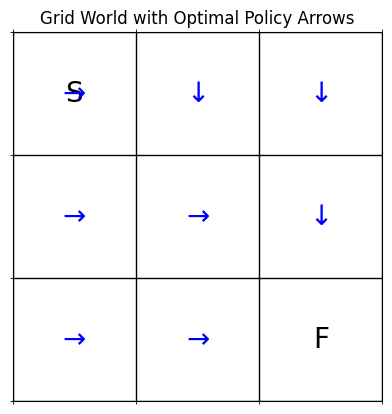

In [27]:
# Initialize the environment
env = GridWorldEnv(grid_size=(3, 3), start=(0, 0), goal=(2, 2))

# Plotting a random policy
plot_grid_with_policy(env)

# we get now the random initialized policy